# 5.4 CNN可视化（2）-可视化过滤器模式

## 整体思路：随机入-->定损数-->降梯度-->升梯度

## 1. 随机入：随机生成一张带有噪声的灰度图像

In [18]:
import numpy as np
import matplotlib.pyplot as plt
#随机生成一张带有噪声的灰度图像，形状为(1,150,150,3)
input_img_data = np.random.random((1, 150, 150, 3))*20 + 128.

In [19]:
input_img_data[0].max()

147.9995073050418

In [20]:
input_img_data[0].min()

128.0002582225161

#### 生成的随机数组无法呈现出有效图像，还需要进行预处理，采用z-score标准化处理方式

In [21]:
#将张量转换为有效图像
def deprocess_image(x):
    #step 1 :对张量标准化，均值为1，标准差为0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    #step 2: 将张量裁切到[0,1]区间
    x += 0.5
    x = np.clip(x, 0, 1)
    
    #step 3: 将张量转换为RGB组
    x *= 255
    x = np.clip(x, 0,255).astype('uint8')
    return x

#### 打印预处理后的随机生成的图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


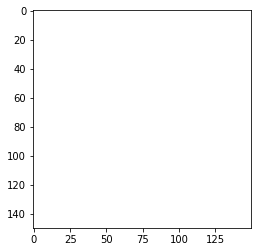

In [22]:
plt.imshow(input_img_data[0])

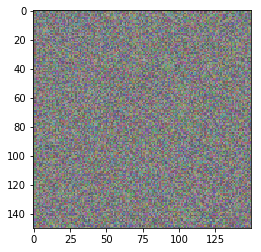

In [23]:
plt.imshow(deprocess_image(input_img_data[0]))

## 2. 定损数：将过滤器的激活输出平均值作为损失函数，即某一过滤器输出的平均值

### 2.1 截取指定层、指定过滤器的输出

In [24]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet', include_top = False)

layer_name = 'block1_conv1'#第一个block中的第一个卷积层
filter_index = 0 #指定该层中第0号过滤器

#定义输出
layer_output = model.get_layer(layer_name).output

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
#因为在vgg16实例化的时候未指定input_shape,因此只能看到每一次层过滤器数目，而没有形状
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 2.2 将过滤器的激活输出平均值定义为损失值

In [26]:
#将0号过滤器的输出平均值定义为损失
loss = K.mean(layer_output[:, :, :, filter_index]) #指定层中的指定通道

## 3. 降梯度：获取损失函数相对于输入图像的梯度

### 3.1 定义梯度

In [27]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution() #需禁用，否则下面求梯度会报错

#定义损失函数相对于输入图像的梯度
grads = K.gradients(loss, model.input)[0]

grads

<tf.Tensor 'gradients/block1_conv1/Conv2D_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

### 3.2 梯度标准化，即均方根运算

In [28]:
#采用L2范数对梯度进行标准化
#平方-->平均-->开方
grads /=  (K.sqrt(K.mean(K.square(grads))) + 1e-5)

### 3.3 定义输入图像、梯度值、损失值之间的函数

In [29]:
#定义模型输入与损失值、梯度值之间的函数关系——iterate
#model.input形状为(,,,3)
iterate = K.function([model.input], [loss, grads])

In [30]:
#函数应用示例
import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])
print('loss_value : ',loss_value)
print('grads_value : ',grads_value)

loss_value :  0.73429114
grads_value :  [[[[ 3.1018138   3.8254216   3.4709406 ]
   [ 1.9110217   2.3392682   2.1691628 ]
   [ 1.9110217   2.3392682   2.1691628 ]
   ...
   [ 1.9110217   2.3392682   2.1691628 ]
   [ 1.9110217   2.3392682   2.1691628 ]
   [-0.04566564 -0.15054011 -0.02717089]]

  [[ 2.213498    2.7437632   2.5371103 ]
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -0.09001549  0.07251131]
   ...
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -0.09001549  0.07251131]
   [-1.7470312  -2.4169104  -1.9824785 ]]

  [[ 2.213498    2.7437632   2.5371103 ]
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -0.09001549  0.07251131]
   ...
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -0.09001549  0.07251131]
   [-1.7470312  -2.4169104  -1.9824785 ]]

  ...

  [[ 2.213498    2.7437632   2.5371103 ]
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -0.09001549  0.07251131]
   ...
   [ 0.0499846  -0.09001549  0.07251131]
   [ 0.0499846  -

## 4.梯度提升，通过梯度下降技术让损失函数最大化，即沿着让损失最大化的方向调节输入图像

In [31]:
#迭代40次，通过梯度下降尽量让损失最大化
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value #梯度提升

In [32]:
#loss_value从最初的0增长为2738
loss_value

9.837243

In [33]:
#grads_value从初始的0转换为以下，形状均为(1,150,150,3)
grads_value

array([[[[ 1.0662794 ,  1.366469  ,  1.1917708 ],
         [ 1.9935142 ,  2.4590757 ,  2.2061026 ],
         [ 1.8411708 ,  2.25701   ,  2.0443606 ],
         ...,
         [ 2.523363  ,  3.1154027 ,  2.8152063 ],
         [ 2.6193988 ,  3.216283  ,  2.9398477 ],
         [-0.04080625, -0.13452078, -0.02427957]],

        [[ 1.7484715 ,  2.2248619 ,  1.9626163 ],
         [ 2.7717423 ,  3.4183493 ,  3.1015894 ],
         [ 1.7076652 ,  2.090341  ,  1.9383368 ],
         ...,
         [ 1.5649846 ,  1.9447637 ,  1.8120338 ],
         [ 0.9138775 ,  1.1237847 ,  1.1038777 ],
         [-1.5611254 , -2.1597211 , -1.7715182 ]],

        [[ 1.6057909 ,  2.0792844 ,  1.8363132 ],
         [ 1.9779544 ,  2.4517927 ,  2.2671301 ],
         [ 0.04466562, -0.08043673,  0.0647952 ],
         ...,
         [ 0.04466562, -0.08043673,  0.0647952 ],
         [-1.0216137 , -1.4469057 , -1.1269755 ],
         [-2.4883604 , -3.252328  , -2.7858498 ]],

        ...,

        [[ 2.5330257 ,  3.1718912 ,  2

## 5.基于前4步，定义一点处理函数

In [34]:
def generate_pattern(layer_name, filter_index, size = 150):
    #计算指定层输出
    layer_output = model.get_layer(layer_name).output
    
    #计算指定层指定通道的平均值作为loss
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    #计算loss函数关于model.input的梯度
    grads = K.gradients(loss, model.input)[0]
    
    #标准化梯度，均方根
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    #建立函数，根据输入返回loss/grades
    iterate = K.function([model.input], [loss, grads])
    
    #初始化一个带有噪声的输入图片
    input_data = np.random.random((1,size,size,3))*20 + 128.
    
    #运行40次梯度提升
    for i in range(40):
        loss_value, grads_value = iterate([input_data])
        input_data += grads_value * 1.
    
    img = input_data[0]
    return deprocess_image(img)

#### 示例：打印block1中的conv1的第1个过滤器响应模式

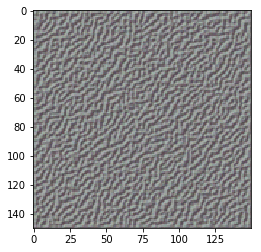

In [35]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern( 'block1_conv1', 0))

## 6 可视化VGG16各模块中的卷积层里的过滤器

### 可视化 block1_conv1 中的过滤器

In [36]:
#指定需要可视化的层名称
layer_name = 'block1_conv1'

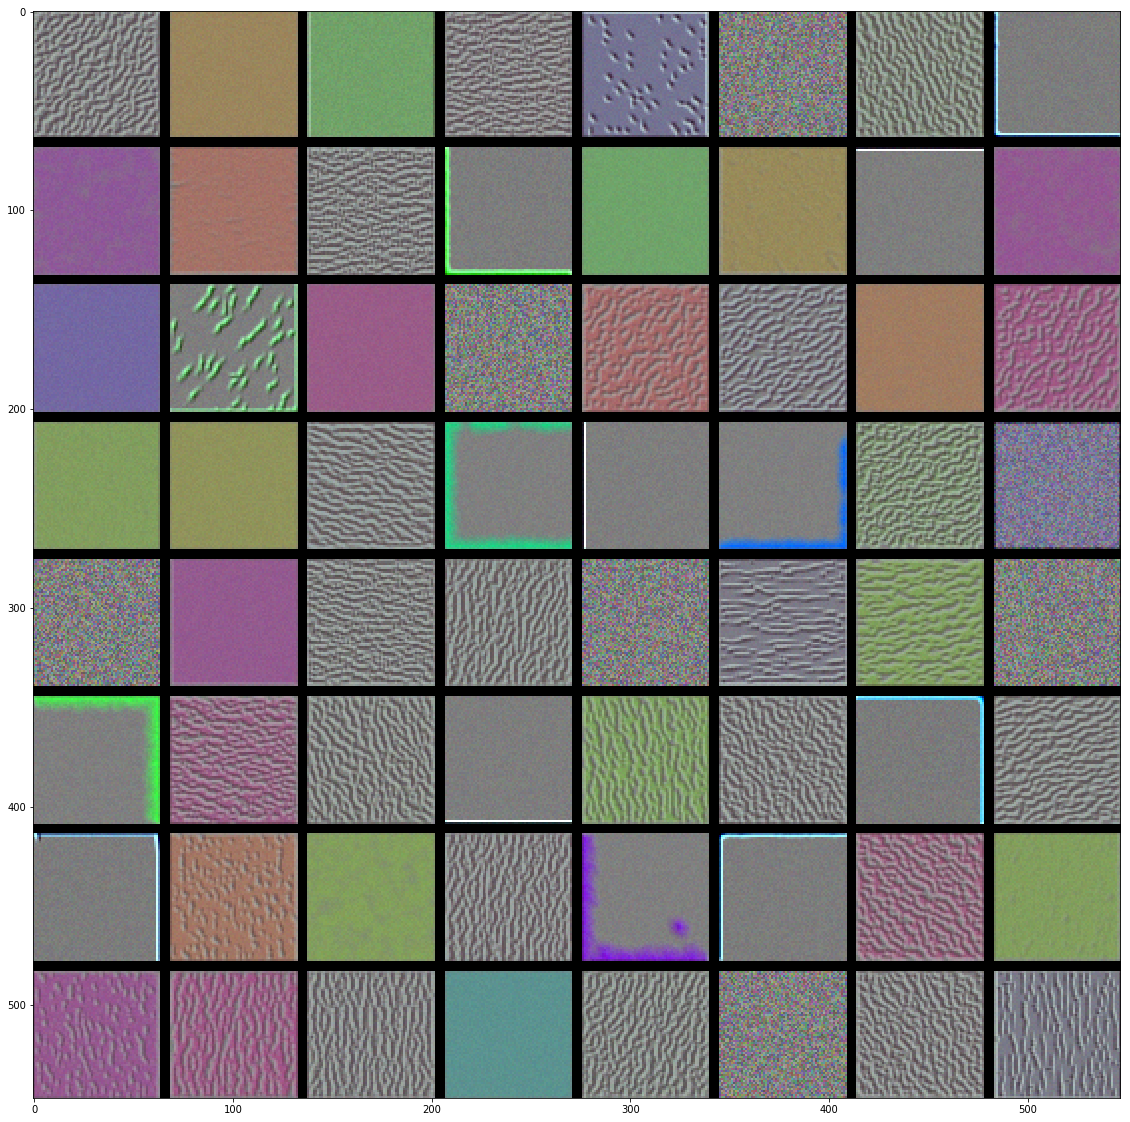

In [37]:
size = 64 #一个格的像素大小,该卷积层
margin = 5 #格与格之间间隔
#用于保存过滤器图像矩阵结果，该卷积层共有64个过滤器，故设置一个8 x 8的矩阵，每一个网格由64 x 64的像素构成
results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3))


#填充网格
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, j + ( i * 8 ), size = 64)
        horizontal_start = i * size + i * margin
        hortzontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:hortzontal_end, vertical_start:vertical_end, :] = filter_img
        
plt.figure(figsize = (20,20))
plt.imshow(results.astype('uint8'))
plt.show()